In [26]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from env import host, user, password

In [27]:
import pandas as pd
import numpy as np
import os
from env import host, user, password
import seaborn as sns
from pydataset import data
import matplotlib.pyplot as plt

from scipy import stats
import explore
import wrangle
import zillow_wrangle
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import decimal as d

# ignore warnings
import warnings
warnings.filterwarnings("ignore")




predict the values of single unit properties that the tax district assesses using the property data from those with a transaction during the "hot months" (in terms of real estate demand) of May-August, 2017.



We would like to know what states and counties these are located in.
We'd also like to know the distribution of tax rates for each county.

The data should have the tax amounts and tax value of the home, so it shouldn't be too hard to calculate.


Please include in your report to us the distribution of tax rates for each county so that we can see how much they vary within the properties in the county and the rates the bulk of the properties sit around.

Note that this is separate from the model you will build, because if you use tax amount in your model, you would be using a future data point to predict a future data point, and that is cheating! 
- In other words, for prediction purposes, we won't know tax amount until we know tax value.


-----------------------------------------------------

First pass is our MVP

- Acquire: whatever SQL query gives us workable data
- Prepare: drop nulls, data split
- Explore: visualize the target against independent variables
- Model: baseline, LinearRegression, LassoLars compare performance with rmse on validate
- NB. not worried about scaling or automated feature engineering

### Acquire:

In [29]:
#created df.
zillow_df = zillow_wrangle.get_zillow()

In [30]:
# 1 object, and rest are numerical float values.
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28418 entries, 0 to 28417
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    28418 non-null  float64
 1   bathroomcnt                   28418 non-null  float64
 2   calculatedfinishedsquarefeet  28345 non-null  float64
 3   unitcnt                       17908 non-null  float64
 4   taxvaluedollarcnt             28417 non-null  float64
 5   yearbuilt                     28322 non-null  float64
 6   taxamount                     28417 non-null  float64
 7   fips                          28418 non-null  float64
 8   parcelid                      28418 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 2.2 MB


In [31]:
# initial look some fields can have dummies generated, taxvalue and tax amount need to be changed to two decimal places fips can be changed to column stating county and state.
zillow_df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,unitcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,parcelid
0,3.0,2.0,1316.0,1.0,205123.0,1923.0,2627.48,6037.0,11721753
1,3.0,2.0,1458.0,1.0,136104.0,1970.0,2319.90,6037.0,11289917
2,2.0,1.0,1421.0,1.0,35606.0,1911.0,543.69,6037.0,11705026
3,4.0,3.0,2541.0,NaN,880456.0,2003.0,9819.72,6059.0,14269464
4,3.0,2.0,1491.0,1.0,107110.0,1955.0,1399.27,6037.0,11446756


In [32]:
#looking into the data types. Unit count has high number of null values.
zillow_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28418 entries, 0 to 28417
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    28418 non-null  float64
 1   bathroomcnt                   28418 non-null  float64
 2   calculatedfinishedsquarefeet  28345 non-null  float64
 3   unitcnt                       17908 non-null  float64
 4   taxvaluedollarcnt             28417 non-null  float64
 5   yearbuilt                     28322 non-null  float64
 6   taxamount                     28417 non-null  float64
 7   fips                          28418 non-null  float64
 8   parcelid                      28418 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 2.2 MB


In [33]:
# shape of our df is 28418 records and 10 fields
zillow_df.shape

(28418, 9)

In [34]:
#quick looks at the stat
zillow_df.describe()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,unitcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,parcelid
count,28418.000000,28418.000000,28345.000000,17908.000000,2.841700e+04,28322.000000,28417.000000,28418.000000,2.841800e+04
mean,3.298086,2.311070,1931.781302,1.001731,5.332912e+05,1963.908128,6486.382513,6050.004012,1.307361e+07
std,0.954759,1.017817,1013.657214,0.055393,7.063144e+05,23.074741,8209.046143,21.915706,3.747577e+06
min,0.000000,0.000000,240.000000,1.000000,1.000000e+03,1878.000000,51.260000,6037.000000,1.071186e+07
25%,3.000000,2.000000,1276.000000,1.000000,1.984120e+05,1950.000000,2690.920000,6037.000000,1.152324e+07
50%,3.000000,2.000000,1669.000000,1.000000,3.807330e+05,1961.000000,4703.700000,6037.000000,1.261153e+07
75%,4.000000,3.000000,2319.000000,1.000000,6.300000e+05,1980.000000,7495.440000,6059.000000,1.416371e+07
max,12.000000,11.000000,35640.000000,4.000000,2.385837e+07,2016.000000,276797.830000,6111.000000,1.676878e+08


### Main Takeaways:
- Initial shape is 28418 records and 9 fields.
- A few of the fields contain null values.
- Looking at initial stats, seems like there is some potential outliers. 
- Implmented a sql query within a function which brings in dataframe filtered to hot months.

-----------------------------

### Remember
#### For the first iteration of your model, use only square feet of the home, number of bedrooms, and number of bathrooms to estimate the property's assessed value, taxvaluedollarcnt. You can expand this to other fields after you have completed an mvp (minimally viable product).

----------------------

### Prepare:

In [35]:
#getting the null count
zillow_df.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet       73
unitcnt                         10510
taxvaluedollarcnt                   1
yearbuilt                          96
taxamount                           1
fips                                0
parcelid                            0
dtype: int64

In [36]:
#shape of the dataframe
zillow_df.shape

(28418, 9)

In [37]:
#see which columns have nulls
zillow_df.columns[zillow_df.isnull().any()]

Index(['calculatedfinishedsquarefeet', 'unitcnt', 'taxvaluedollarcnt',
       'yearbuilt', 'taxamount'],
      dtype='object')

In [38]:
explore.miss_dup_values(zillow_df)

Your selected dataframe has 9 columns.
There are 5 columns that have missing values.
  
** There are 26 duplicate rows that represents 0.09% of total Values**


,Missing Values,% of Total Values
unitcnt,10510,37.0
yearbuilt,96,0.3
calculatedfinishedsquarefeet,73,0.3
taxvaluedollarcnt,1,0.0
taxamount,1,0.0


In [39]:
#dropping duplicate values
zillow_df.drop_duplicates()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,unitcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips,parcelid
0,3.0,2.0,1316.0,1.0,205123.0,1923.0,2627.48,6037.0,11721753
1,3.0,2.0,1458.0,1.0,136104.0,1970.0,2319.90,6037.0,11289917
2,2.0,1.0,1421.0,1.0,35606.0,1911.0,543.69,6037.0,11705026
3,4.0,3.0,2541.0,NaN,880456.0,2003.0,9819.72,6059.0,14269464
4,3.0,2.0,1491.0,1.0,107110.0,1955.0,1399.27,6037.0,11446756
...,...,...,...,...,...,...,...,...,...
28413,6.0,2.0,2634.0,1.0,878190.0,1921.0,12766.88,6037.0,11991766
28414,4.0,1.5,1187.0,NaN,465999.0,1959.0,5552.68,6059.0,14011468
28415,5.0,3.0,3015.0,NaN,852813.0,2002.0,11662.88,6059.0,14453399
28416,5.0,3.0,2992.0,1.0,1120000.0,1977.0,13663.03,6037.0,11128688


In [40]:
#swithcing parcel_id to index
zillow_df.set_index('parcelid', drop = True, inplace = True)
#are there any empty records? replaced the empty values with NaN
zillow_df.replace(' ', np.nan, inplace = True)


In [41]:
zillow_df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,unitcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips
parcelid,,,,,,,,
11721753,3.0,2.0,1316.0,1.0,205123.0,1923.0,2627.48,6037.0
11289917,3.0,2.0,1458.0,1.0,136104.0,1970.0,2319.90,6037.0
11705026,2.0,1.0,1421.0,1.0,35606.0,1911.0,543.69,6037.0
14269464,4.0,3.0,2541.0,NaN,880456.0,2003.0,9819.72,6059.0
11446756,3.0,2.0,1491.0,1.0,107110.0,1955.0,1399.27,6037.0


In [42]:
def view_null_records(df, variable):
    """
    function allows you to records which contain null, nan values.
    REMEMBER, will only work for individual column and if that columns has nulls, 
    otherwise will return empty dataframe
    """
    df  = df[df[variable].isna()]
    
    return df


In [43]:
view_null_records(zillow_df, 'calculatedfinishedsquarefeet')

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,unitcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips
parcelid,,,,,,,,
14430658,0.0,0.0,NaN,NaN,5346951.0,NaN,82484.04,6059.0
11999890,0.0,0.0,NaN,NaN,2578702.0,NaN,30456.40,6037.0
14466991,0.0,0.0,NaN,NaN,2493444.0,NaN,25740.28,6059.0
13972530,0.0,0.0,NaN,NaN,270009.0,NaN,3230.88,6059.0
14325627,0.0,0.0,NaN,NaN,7074075.0,NaN,81640.56,6059.0
12686981,0.0,0.0,NaN,NaN,5461875.0,NaN,60905.26,6037.0
10746614,0.0,0.0,NaN,NaN,230876.0,NaN,2842.21,6037.0
14175690,0.0,0.0,NaN,NaN,157074.0,NaN,2053.88,6059.0
12131538,0.0,0.0,NaN,NaN,225126.0,NaN,2736.14,6037.0


In [44]:
view_null_records(zillow_df, 'taxvaluedollarcnt')

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,unitcnt,taxvaluedollarcnt,yearbuilt,taxamount,fips
parcelid,,,,,,,,
14006983,4.0,2.0,1197.0,NaN,NaN,1954.0,388.18,6059.0


In [45]:
#are there any empty records? replaced the empty values with NaN
zillow_df.replace(r'^\s*$', np.nan, regex=True, inplace = True)

In [46]:
# so after reviewing the two columns taxvalue and sqrft, i feel comfortable dropping the NaN values
zillow_df.dropna(inplace = True)

In [47]:
#just going to utilize 4 features for MVP as stated in curriculum. Created new df which conatins the four features.
zillow = zillow_df[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet','taxvaluedollarcnt']]
zillow.rename(columns = {'calculatedfinishedsquarefeet':'total_squareft','taxvaluedollarcnt': 'assessment_value'},  inplace = True)
zillow.head()

,bedroomcnt,bathroomcnt,total_squareft,assessment_value
parcelid,,,,
11721753,3.0,2.0,1316.0,205123.0
11289917,3.0,2.0,1458.0,136104.0
11705026,2.0,1.0,1421.0,35606.0
11446756,3.0,2.0,1491.0,107110.0
11389003,3.0,2.0,1650.0,614000.0


In [48]:
view_null_records(zillow, 'total_squareft')

,bedroomcnt,bathroomcnt,total_squareft,assessment_value
parcelid,,,,


In [49]:
#need to change bed, bath count, sqrt feat to int, round tax value to 2 decimal places.
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17901 entries, 11721753 to 10713993
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bedroomcnt        17901 non-null  float64
 1   bathroomcnt       17901 non-null  float64
 2   total_squareft    17901 non-null  float64
 3   assessment_value  17901 non-null  float64
dtypes: float64(4)
memory usage: 699.3 KB


In [50]:
zillow.bedroomcnt.value_counts()

3.0     8293
4.0     4485
2.0     3415
5.0     1177
1.0      251
6.0      203
7.0       33
0.0       25
8.0        7
9.0        4
11.0       3
12.0       3
10.0       2
Name: bedroomcnt, dtype: int64

In [24]:
zillow = zillow.astype({'total_squareft':'int',  'assessment_value': 'int'})


In [25]:
zillow.head()

,bedroomcnt,bathroomcnt,total_squareft,assessment_value
parcelid,,,,
11721753,3.0,2.0,1316,205123
11289917,3.0,2.0,1458,136104
11705026,2.0,1.0,1421,35606
11446756,3.0,2.0,1491,107110
11389003,3.0,2.0,1650,614000


In [26]:
zillow.describe()

,bedroomcnt,bathroomcnt,total_squareft,assessment_value
count,17901.000000,17901.000000,17901.000000,1.790100e+04
mean,3.207363,2.209793,1830.067091,5.068701e+05
std,0.953508,1.058020,1023.857258,7.795366e+05
min,0.000000,0.000000,240.000000,1.000000e+03
25%,3.000000,2.000000,1212.000000,1.675160e+05
50%,3.000000,2.000000,1569.000000,3.291880e+05
75%,4.000000,3.000000,2149.000000,5.615590e+05
max,12.000000,11.000000,35640.000000,2.385837e+07


In [27]:
# need to deal with outliers
#can calculate interquartile range.
#then exclude those outside those values.

In [28]:
def outlier_bound_calculation(df, variable):
    '''
    calcualtes the lower and upper bound to locate outliers in variables
    '''
    quartile1, quartile3 = np.percentile(df[variable], [25,75])
    IQR_value = quartile3 - quartile1
    lower_bound = quartile1 - (1.5 * IQR_value)
    upper_bound = quartile3 + (1.5 * IQR_value)
    '''
    returns the lowerbound and upperbound values
    '''
    return print(f'For {variable} the lower bound is {lower_bound} and  upper bound is {upper_bound}')    

In [29]:
# looking into outliers
outlier_bound_calculation(zillow, 'bedroomcnt')

For bedroomcnt the lower bound is 1.5 and  upper bound is 5.5


In [30]:
# looking into outliers
outlier_bound_calculation(zillow, 'bathroomcnt')

For bathroomcnt the lower bound is 0.5 and  upper bound is 4.5


In [31]:
# looking into outliers
outlier_bound_calculation(zillow, 'total_squareft')

For total_squareft the lower bound is -193.5 and  upper bound is 3554.5


In [32]:
# looking into outliers
outlier_bound_calculation(zillow, 'assessment_value')

For assessment_value the lower bound is -423548.5 and  upper bound is 1152623.5


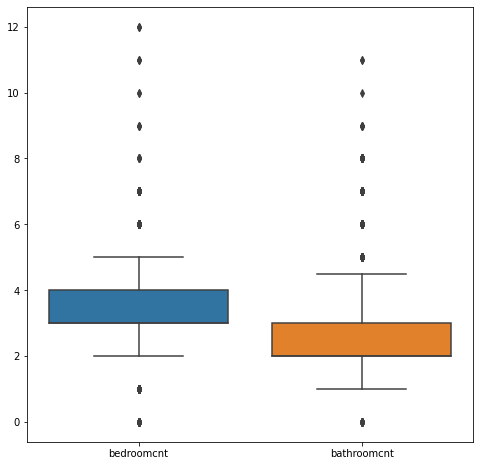

In [33]:
#vizualize the outliers
plt.figure(figsize=(8,8))
# Create boxplots for all but student_id.
sns.boxplot(data=zillow.drop(columns=['assessment_value','total_squareft']),)
plt.show()

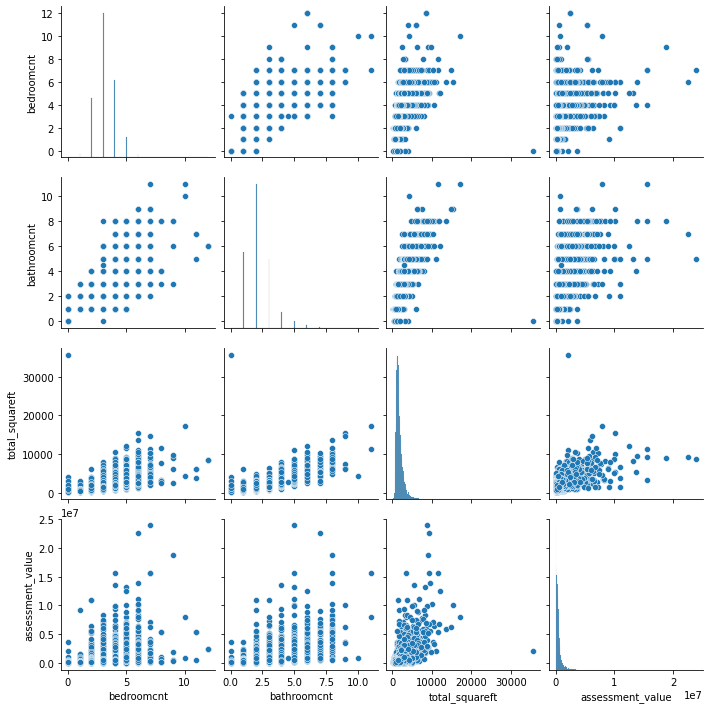

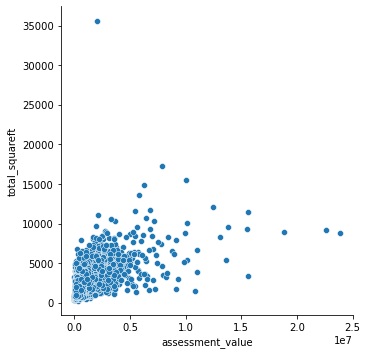

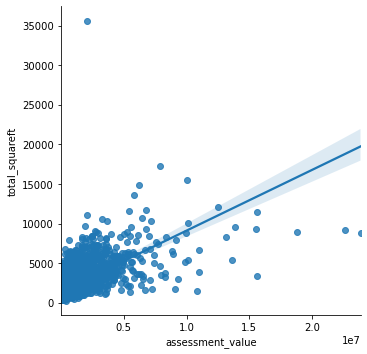

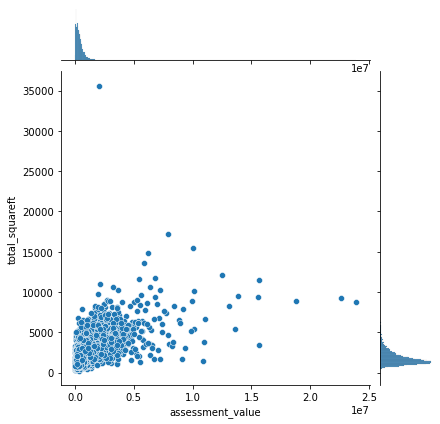

In [34]:
explore.continuous_with_continuous(zillow,'assessment_value','total_squareft', hue = None, col = None )

In [35]:
#dropping outliers
zillow = zillow[(zillow['assessment_value'] < 1152623.5)& (zillow['assessment_value']>0)]
zillow = zillow[(zillow['total_squareft'] < 3554.5) & (zillow['total_squareft']>0)]
zillow = zillow[(zillow['bedroomcnt'] < 5.5) &  (zillow['bedroomcnt']>1.5)]
zillow = zillow[(zillow['bathroomcnt'] < 4.5) & (zillow['bathroomcnt']>0.5)]
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15696 entries, 11721753 to 10713993
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bedroomcnt        15696 non-null  float64
 1   bathroomcnt       15696 non-null  float64
 2   total_squareft    15696 non-null  int64  
 3   assessment_value  15696 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 613.1 KB


In [36]:
#splitting into a train, validate and test dataset.
train, validate, test = wrangle.split_continuous(zillow)

train -> (8789, 4)
validate -> (3767, 4)
test -> (3140, 4)


In [37]:
train.bedroomcnt.value_counts()

3.0    4392
4.0    2149
2.0    1854
5.0     394
Name: bedroomcnt, dtype: int64

In [38]:
train.bathroomcnt.value_counts()

2.0    4398
1.0    2249
3.0    1911
4.0     231
Name: bathroomcnt, dtype: int64

In [34]:
train.head()

,bedroomcnt,bathroomcnt,total_squareft,assessment_value
parcelid,,,,
11158289,4.0,2.0,1250,421328
11275603,3.0,2.0,1646,188393
12451957,3.0,1.0,1003,397000
12163042,3.0,2.0,1629,490990
12044709,2.0,1.0,809,518792


### Main Takeaway:
- Doing house cleaning: dropping duplciates, dropping nans, and set parcelid to index.
- Calculated outliers for each field, dropped these outliers.
- Made some simple charts to visualize outliers
- split the zillow df into a train, validate, test datasets.
- DF shape now 15697 records and 4 fields

----------------------------------

### Explore:

#### Data Exploration

##### Goal: I recommend following the exploration approach of univariate, bivariate, multivariate discussed in class. In that method, you can address each of the questions you posed in your planning and brainstorming and any others you have come up with along the way through visual exploration and statistical analysis. The findings from your analysis should provide you with answers to the specific questions your customer asked that will be used in your final report as well as information to move forward toward building a model.

- Think about the following in this stage:

    -  Run at least 1 t-test and 1 correlation test (but as many as you need!)

    -  Visualize all combinations of variables in some way(s).

    - What independent variables are correlated with the dependent?

    - Which independent variables are correlated with other independent variables?

    - Make sure to summarize your takeaways and conclusions. That is, the Zillow data science team doesn't want to see just a bunch of dataframes, numbers, and charts without any explanation; you should explain in the notebook what these mean, interpret them.
    
    - Identitfy features that correlate with each other. If feature A and feature B are each tightly correlated with the target variable, but they're also tightly correlated with each other, we should use one feature that correlates better, rather than use both.
    - Test Your Hypotheses: Analyze the drivers of a continuous target variable using the appropriate statistical tests (t-tests, correlation, and chi-squared hypothesis tests).

In [35]:
# Remember the goal here im a zillow employee 
# For the first iteration of your model, use only square feet of the home, 
# number of bedrooms, and number of bathrooms to estimate the property's assessed value, taxvaluedollarcnt.

In [36]:
cat_vars = ['bedroomcnt', 'bathroomcnt']
quant_vars = ['total_squareft','assessment_value']

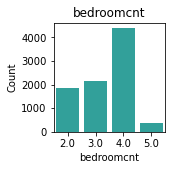

     bedroomcnt  Count  Percent
3.0         4.0   4392    49.97
4.0         3.0   2149    24.45
2.0         2.0   1854    21.09
5.0         5.0    394     4.48
_________________________________________________________________


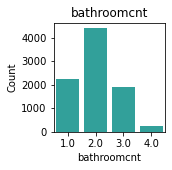

     bathroomcnt  Count  Percent
2.0          2.0   4398    50.04
1.0          1.0   2249    25.59
3.0          3.0   1911    21.74
4.0          4.0    231     2.63
_________________________________________________________________


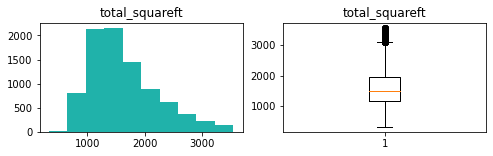

count    8789.000000
mean     1624.072363
std       588.375606
min       326.000000
25%      1183.000000
50%      1502.000000
75%      1946.000000
max      3553.000000
Name: total_squareft, dtype: float64


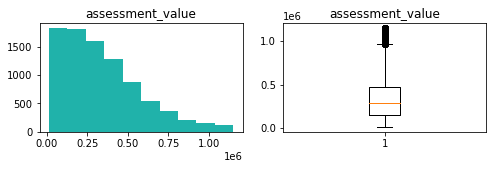

count    8.789000e+03
mean     3.432832e+05
std      2.404535e+05
min      1.428400e+04
25%      1.515290e+05
50%      2.943840e+05
75%      4.780000e+05
max      1.152372e+06
Name: assessment_value, dtype: float64


In [37]:
# looking at each individual field.
# can see most bedroom are 3 and bath are 3, 
# total_squareft and assessment appear to be normally distributed.
explore.explore_univariate(train, cat_vars, quant_vars)

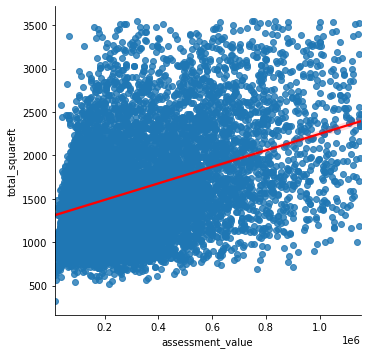

In [38]:
# there isnt really a visible trend, an assumption can be made whiich as totalsquareft increase assessment_value increases.
sns.lmplot(x = 'assessment_value', y = 'total_squareft' , data = train, line_kws={'color': 'red'})

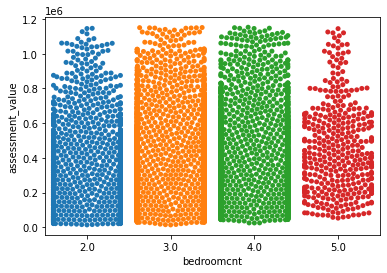

KeyboardInterrupt: 

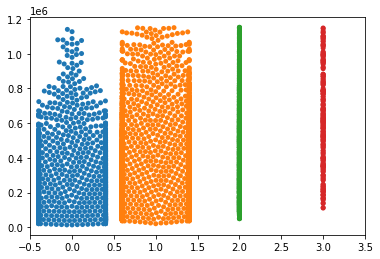

In [39]:
#discrete vs continous
# plots are unproductive not much value.
sns.swarmplot(x='bedroomcnt', y='assessment_value', data=train)
plt.show()
sns.swarmplot(x='bathroomcnt', y='assessment_value', data=train)
plt.show()

In [ ]:
#a bedroom count of 5 has the max value when it comes to assessment_value
# again 4 bathroom being the most has the max assessment_value.
sns.barplot(x='bedroomcnt', y='assessment_value', data=train)

In [ ]:
sns.barplot(x='bathroomcnt', y='assessment_value', data=train)

In [ ]:
# so after reviewing this information, it would be best to bin both bed and bath.